<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>
<b> Optoélectronique GEL-4203 / GEL-7041 </b><br>
<b> Département de Génie Électrique et de Génie Informatique </b><br>
<b> Automne 2025 </b><br>
<b> Université Laval </b><br>


<h1><center> Travail 3 </center></h1>

##### Remise 
- Votre notebook (.ipynb) ou un document au format PDF contenant vos démarches, réponses clairement identifiées et vos scripts (Python, Matlab ou autre
- Sur la boîte de dépôt dans monportail
- Au plus tard le "à déterminer"
##### Équipe
- Ce travail est *individuel*

##### Pondération : 
<!-- - GEL-4203 : Ce travail vaut pour *5%* de la note finale
- GEL-7041 : Ce travail vaut pour *5%* de la note finale -->

## Identification
- **Nom** : Éloi Blouin
- **Matricule** : 536 999 917

## Consignes pour répondre aux questions
- Utilisez des cellules de Markdown pour fournir des explications écrites et des équations mathématiques.
    - Vous pouvez faire une équation $\LaTeX$ sur une ligne: $\sum_{n = 0}^\infty x^n$.
    - Vous pouvez faire une équation $\LaTeX$ centrée: $$\sum_{n = 0}^\infty x^n.$$
    - Vous pouvez imbriquer des listes:
        - Niveau 2
            - Niveau 3
- Utilisez des cellules de code pour effectuer vos calculs numériques. Prenez soin de bien commenter votre code, de choisir des noms de variables explicites et de "print()" vos réponses.
- N'hésitez-pas à encapsuler vos calculs répétés dans des fonctions. À plusieurs endroits, il vous sera suggéré de créer des fonctions spécifiques. Ce n'est pas obligatoire mais fortement conseillé.
- Seules les librairies suivantes sont permises. Parmi celles-ci figure les fonctions de résolution de guide d'onde 1D.

In [408]:
""" 
Librairies permises
N'utilisez que les librairies Python suivantes
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
import types
from GEL4203_utils import guide_1d_analytique

In [409]:
def reset_globals_variables():
    """ Supprime toutes les variables globales sauf les fonctions et les modules importés """
    
    # Obtenir la liste des noms dans l'espace global
    current_globals = list(globals().keys())

    for name in current_globals:
        # 1. Skip names that start with an underscore (Python's convention for "internal" names)
        if name.startswith('_'):
            continue

        # 2. Get the object associated with the name
        obj = globals()[name]

        # 3. Skip imported packages (modules), functions, and classes
        if isinstance(obj, types.ModuleType) or isinstance(obj, types.FunctionType) or isinstance(obj, type):
            continue

        # 4. If it's a regular variable, delete it
        del globals()[name]


### Question 1 - Conception d'une cavité Fabry-Péro (10%)
Pour ce problème, vous pouvez ignorer les effets de dispersion. Considérez un guide d'onde dont l'indice effectif est 2.45. À partir de ce guide d'onde, vous concevez une cavité Fabry-Pérot. Les pertes dans le guide d'onde sont $\alpha = 10$ dB/cm. Coefficient de réflexion des facettes est r = $r_1$ = $r_2$ avec $  r^2 + t^2=1 $.  La longueur de la cavité est L.

##### 1.A (2.5 points) Démontrez que les longueurs d'ondes résonantes obéissent la relation:
$$ \lambda_{res} = \frac{2 n_{eff} L}{m}. $$

L'onde électromagnétique oscille selon 
$$
\vec{E} = E_0 e^{i(kz + ωt)}
$$
Pour arrivé en résonance, elle doit arrivé en phase avec elle même lors d'une oscillation dans la cavité de longueur $z=2L$ alors elle doit parcourir une phase de $δ =m2π$ ou $m \in \mathbb{N}$. Ainsi,
$$
k⋅z = 2πm\\
k⋅2L = \cfrac{2πn}{λ}⋅2L = 2πm\\
 λ  = \cfrac{2Ln}{m}
$$
À noter que si l'onde se déplace dans une guide d'onde avec plusieurs indice de réfraction, on doit prendre l'indice effective du mode. Ainsi
$$
λ_{res} = \cfrac{2n_{eff}L}{m} \quad\quad \text{où } m \in \mathbb{N}
$$

In [410]:
n_eff_num1 = 2.45
α_dB_num1 = 10  # en dB/cm

##### 1.B (2.5 points) Vous devez aligner un laser émettant à 1300 nm directement sur la résonance $m=100$. Quelle doit être la longueur de la cavité $L$?

In [411]:
def calculate_length_cavity(λ,m, n_eff):
    """ Calcule la longueur de cavité pour une résonance donnée

    Paramètres:
        λ : longueur d'onde en m
        m : ordre de la résonance (entier)
        n_eff : indice effectif du mode dans la cavité

    Retourne:
        L : longueur de la cavité en m
    """
    L = m * λ / (2 * n_eff)
    return L

In [412]:
λ_1_num1 = 1300E-9  # en m
m_1_num1 = 100

L_num1 = calculate_length_cavity(λ_1_num1, m_1_num1, n_eff_num1)
print(f"La longueur de la cavité est de {L_num1*1e6:.3f} µm")


La longueur de la cavité est de 26.531 µm


##### 1.C (2.5 points) Quel est l'interval spectral libre (FSR) en nanomètres et en fréquences à 1300 nm?

L'équation pour le FSR et le facteur de qualité est 
$$
FSR = \frac{λ^2}{2n_{eff}L}\\
Q = \frac{π\sqrt{R}}{1-r} = \frac{FSR}{FWHM}
$$

In [413]:
def calculate_FSR(λ, L, n_eff):
    """ Calcule le Free Spectral Range (FSR) d'une cavité résonante

    Paramètres:
        λ : longueur d'onde en m
        L : longueur de la cavité en m
        n_eff : indice effectif du mode dans la cavité

    Retourne:
        FSR : Free Spectral Range en m
    """
    FSR = λ**2 / (2 * n_eff * L)
    return FSR

In [414]:
FSR_num1 = calculate_FSR(λ_1_num1, L_num1, n_eff_num1)
print(f"Le FSR est de {FSR_num1*1e9:.3f} nm")

Le FSR est de 13.000 nm


Le facteur de qualité (Q) d'une cavité Fabry-Pérot donne une indication sur la capacité de la cavité résonante à selectionner une fréquence. Le facteur de qualité peut être exprimé par:
$$ Q = \frac{2 \pi  f n_g L}{c A} =  \frac{f}{\Delta f_{1/2}} $$

où A = $\alpha L -\ln(\sqrt{r_1^2 r_2^2})$ est la fraction de puissance perdue par aller-retour dans le résonateur, $\alpha$ est le coefficient de perte du guide d'onde [1/m], $n_g$ est l'indice de groupe (ici $n_g$ = neff car on ne considère pas la dispersion), $f$ est la fréquence centrale, $\Delta f_{1/2}$ est la largeur des résonances en fréquence et L est la longueur de la cavité. 

##### 1.D (2.5 points) Quelle doit être la valeur de $r$ pour optimiser le facteur Q?


Intuitivement plus les factelle de la cavité seront réfléchissante, plus le réseau sera sélectif et aura un facteur de qualité élevé
$$ 
Q = \frac{2 \pi  n_{eff} L}{λ(αL - \ln(r^2))} = \frac{2 \pi  n_{eff}}{λ(α - \frac{\ln(r^2)}{L})} 
$$

In [415]:
def calculate_Q(λ, α, L, r_1, r_2, n_eff):
    f = cte.c / λ
    α_lin = (α / 4.343) * 100  # Convertir dB/cm en 1/m

    Q = (2 * np.pi * n_eff) / (λ * (α_lin - (np.log(np.sqrt(r_1**2 *r_2**2)) / L)))

    return Q

Le facteur de qualité Q pour r_1 = r_2 = 1.00 est de 51427.15


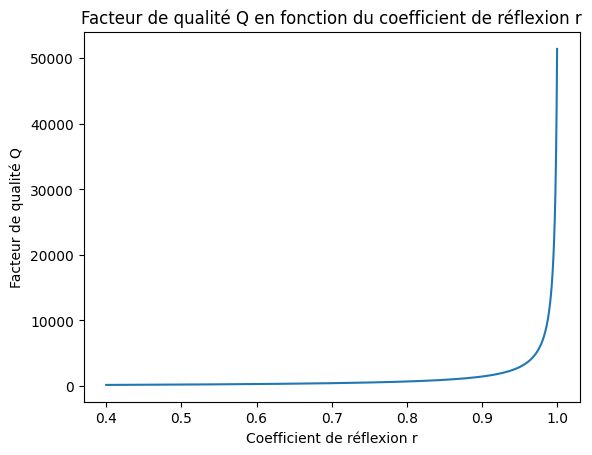

In [416]:
r_num1 = np.linspace(0.4, 1, 10000)
Q_num1 = calculate_Q(λ_1_num1, α_dB_num1, L_num1, r_num1, r_num1, n_eff_num1)
print(f"Le facteur de qualité Q pour r_1 = r_2 = {r_num1[-1]:.2f} est de {Q_num1[-1]:.2f}")

plt.plot(r_num1, Q_num1)
plt.xlabel("Coefficient de réflexion r")
plt.ylabel("Facteur de qualité Q")
plt.title("Facteur de qualité Q en fonction du coefficient de réflexion r")
plt.show()

Ici le facteur de qualité est limité par la perte de propagation de la cavité, par exemple pour $α = 50 \ [dB/cm]$ on obtient des valeurs différente.

In [417]:
α_2_num1 = 50  # en dB/cm
Q_2_num1 = calculate_Q(λ_1_num1, α_2_num1, L_num1, r_num1, r_num1, n_eff_num1)
print(f"Le facteur de qualité Q pour r_1 = r_2 = {r_num1[-1]:.2f} et α = {α_2_num1} dB/cm est de {Q_2_num1[-1]:.2f}")


Le facteur de qualité Q pour r_1 = r_2 = 1.00 et α = 50 dB/cm est de 10285.43


##### 1.E (2.5 points) Tracez la transmittance en dB de la cavité FP. Choisissez une plage de longueur d'onde autour de 1300 nm afin qu'on puisse observer 3 résonances. (supposer que r = 0.99 et que L est la valeur trouvée en B).

Nous devons à chaque longueur d'onde calculer la transmittance de la cavité, c'est à dire la fraction de puissance provenant d'un millieu $1$ qui sera transmit au millieu $3$ passant par la cavité le millieu $2$.

On prend la fonction de transfert de transfert d'une cavité fabry-pérot qui dicte l'intensité du champ électrique incidente et transmise.

$$
\frac{E_t}{E_{in}} = \cfrac{t_1t_2e^{-iβL}}{1-r_1r_2e^{-i2βL}}
$$

Je supose que nous somme à incidence normal alors
$$
β = kcos(θ) = k_0 \cos(0) = \frac{2πn}{λ}\\
$$

Comme nous avons aussi une atténuation dans le milieux, il faut prendre en compte la constante de propagation complexe qui transforme la fonction de transfert du FP.
$$ γ = β+ i α/2 $$
$$  \frac{E_t}{E_{in}} = \cfrac{t_1t_2e^{-iβL}e^{-αL/2}}{1-r_1r_2e^{-i2βL}e^{-αL/2}}    $$


Et le coefficient de réflection et transmission aux interfaces sont 
$$ R_{int}+T_{int}=1 \quad\bigg|\quad R_{int} = r^2 \quad\bigg|\quad T_{int} = t^2\\ $$
$$ r_1^2 + t_1^2 = 1 $$
$$ t_1 = \sqrt{1-r_1^2} $$

Ensuite, pour trouvé la transmitance, on doit mettre au carré la norme du ratio des amplitudes du champ électrique transmis et incident.
$$ T = \frac{\text{Intensité}_{t}}{\text{Intensité}_{in}} = \left|\frac{E_t}{E_{in}}\right|^2  = \left|\cfrac{t_1t_2e^{-iβL}e^{-αL/2}}{1-r_1r_2e^{-i2βL}e^{-αL/2}}\right|^2  $$

In [418]:
def calculate_γ(λ, n_eff, α_dB, θ):
    """ Calcule la constante de propagation complexe γ
    Prend la longueur d'onde λ, l'indice effectif n_eff, la perte α en dB/cm et l'angle θ en radians

    returns:
        γ : constante de propagation complexe
    """
    α_lin = (α_dB / 4.343) * 100  # Convertir dB/cm en 1/m

    # Attention α est une atténuation, donc on ajoute un terme imaginaire positif pour qu'il y ait une décroissance
    k = 2 * np.pi * n_eff / λ

    γ = k * np.cos(θ) - 1j * α_lin/2
    return γ


def calculate_FP_transfert_function(γ, L, r_1, r_2, t_1, t_2):
    """ Calcule la fonction de transfert d'une cavité de Fabry-Perot

    Paramètres:
        γ : constante de propagation complexe
        L : longueur de la cavité en m
        r_1, r_2 : coefficients de réflexion des miroirs

    Retourne:
        H : fonction de transfert complexe
    """
    
    H = (t_1 * t_2 * np.exp(-1j * γ * L)) / (1 - r_1 * r_2 * np.exp(-1j * 2 * γ * L))
    return H

def calculate_transmission(H=None, γ=None, L=None, r_1=None, r_2=None, t_1=None, t_2=None):
    """ Calcule la transmission d'une cavité de Fabry-Perot

    Paramètres:
        H (optional): La fonction de transfert complexe pré-calculée.
        γ, L, r_1, r_2, t_1, t_2 : arguments requis si H n'est pas fourni.

    Retourne:
        T : transmission (réelle)
    """
    
    # Check if H is provided
    if H is None:
        # If H is NOT provided, all other arguments must be present to calculate it.
        # Check for missing required arguments
        if None in (γ.all(), L, r_1, r_2, t_1, t_2):
            raise ValueError(
                "If 'H' is not provided, all arguments (γ, L, r_1, r_2, t_1, t_2) must be supplied."
            )
            
        # Calculate H using the required arguments
        H = calculate_FP_transfert_function(γ, L, r_1, r_2, t_1, t_2)
        
    # Proceed with the main calculation
    T = np.abs(H)**2
    return T

def lin_to_dB(value):
    """ Convertit une valeur linéaire en décibels (dB) """
    return 10 * np.log10(value)

def dB_to_lin(value_dB):
    """ Convertit une valeur en décibels (dB) en valeur linéaire """
    return 10 ** (value_dB / 10)

t_num1 = 0.141 | r_num1 = 0.990
L_num1 = 2.653e-05 m | n_eff_num1 = 2.450 | α_dB_num1 = 10 dB/cm


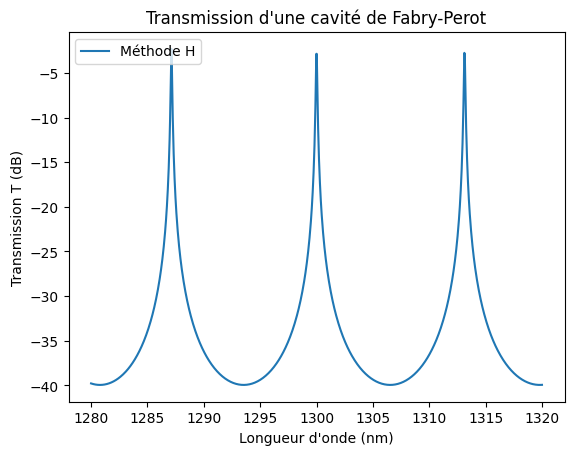

In [419]:
λ_list_num1 = np.linspace(1280e-9, 1320e-9, 1000)
r_num1 = 0.99
t_num1 = np.sqrt(1-r_num1**2)


print(f"t_num1 = {t_num1:.3f} | r_num1 = {r_num1:.3f}")
print(f"L_num1 = {L_num1:.3e} m | n_eff_num1 = {n_eff_num1:.3f} | α_dB_num1 = {α_dB_num1} dB/cm")

# Calcul de γ pour chaque λ
γ_num1 = calculate_γ(λ_list_num1, n_eff_num1, α_dB_num1, 0)
# Calcul de la fonction de transfert H
H_num1 = calculate_FP_transfert_function(γ_num1, L_num1, r_num1, r_num1, t_num1, t_num1)
# Calcul de la transmission T
T_num1 = calculate_transmission(H=H_num1)


plt.plot(λ_list_num1*1e9, lin_to_dB(T_num1), label="Méthode H")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Transmission T (dB)")
plt.title("Transmission d'une cavité de Fabry-Perot")
plt.legend()
plt.show()




On oberse bien plusieurs pics au longueur d'onde de résonance de la cavité FB. Regardons l'influence du coefficient de réflexion de la cavité


In [420]:
def calculate_transmission_FP(λ, L, n_eff, α_dB, r_1, r_2):
    """ Calcule la transmission d'une cavité de Fabry-Perot

    Paramètres:
        λ : longueur d'onde en m
        L : longueur de la cavité en m
        n_eff : indice effectif du mode dans la cavité
        α_dB : perte en dB/cm
        r_1, r_2 : coefficients de réflexion des miroirs

    Retourne:
        T : transmission (réelle)
    """
    t_1 = np.sqrt(1 - r_1**2)
    t_2 = np.sqrt(1 - r_2**2)

    γ = calculate_γ(λ, n_eff, α_dB, 0)
    T = calculate_transmission(γ=γ, L=L, r_1=r_1, r_2=r_2, t_1=t_1, t_2=t_2)

    return T

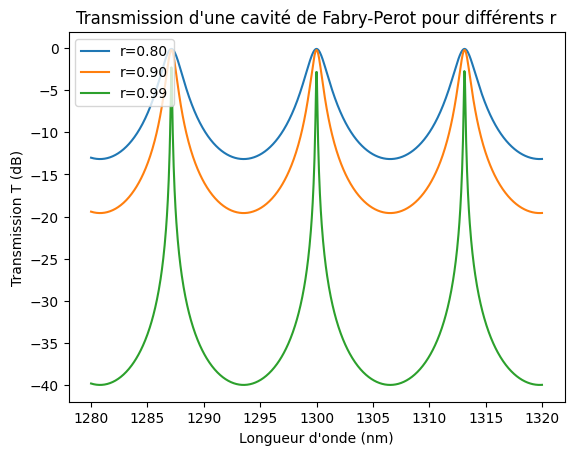

In [421]:
r_list_num1 = [0.8, 0.9, 0.99]
for r in r_list_num1:
    T_num1 = calculate_transmission_FP(λ_list_num1, L_num1, n_eff_num1, α_dB_num1, r, r)
    plt.plot(λ_list_num1*1e9, lin_to_dB(T_num1), label=f"r={r:.2f}")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Transmission T (dB)")
plt.title("Transmission d'une cavité de Fabry-Perot pour différents r")
plt.legend()
plt.show()

On remarque que oui la finesse augmente avec le coefficient de réflexion mais l'atténuation selon la distance diminue aussi l'amplitude. On se retouve ainsi avec un compromis à faire entre FWHM et amplitud/perte.

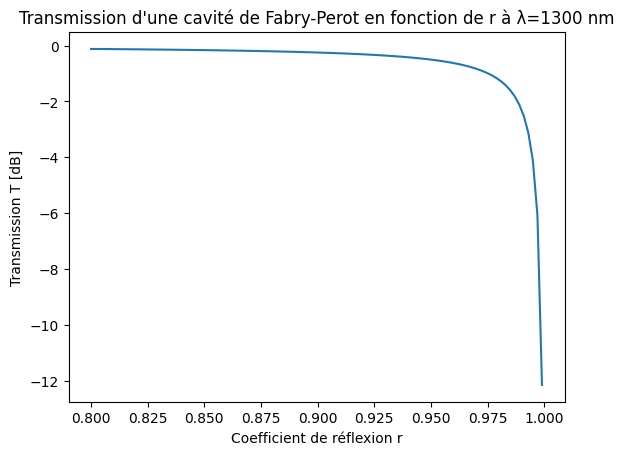

In [422]:
r_list_num1 = np.linspace(0.8, 0.999, 100)

T_max_at_r = []
for i in range(len(r_list_num1)):
    r = r_list_num1[i]
    T_num1 = calculate_transmission_FP(λ_1_num1, L_num1, n_eff_num1, α_dB_num1, r, r)
    T_max_at_r.append(T_num1)

plt.plot(r_list_num1, lin_to_dB(T_max_at_r))
plt.xlabel("Coefficient de réflexion r")
plt.ylabel("Transmission T [dB]")
plt.title("Transmission d'une cavité de Fabry-Perot en fonction de r à λ=1300 nm")
plt.show()

### Question 2 - Laser multimode (20%)

In [423]:
reset_globals_variables()
# Clean up global variables before next question


Considérez un laser multimode basé sur une cavité Fabry-Perot ayant les propriétés suivantes:

| Paramètres du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
| Longueur de la cavité | $L$ | 100 | $\mu m$ |
| Facteur de confinement | $\Gamma$ | 0.1 | - |
| Indice de groupe | $n_g$ | 4.5 | - |
| Coefficient de réflexion des miroirs | $r_{1,2}$ | 0.8, 0.99 | - |
| Coefficient de pertes | $\alpha_i$ | 500 | $m^{-1}$ |
| Longueur d'onde centrale du gain | $\lambda_0$ | 0.95 | $\mu m$|
| Coefficient de gain nominal | $g_0$ | 2000 | cm $^{-1}$ |
| Largeur à mi-hauteur du gain | $\Delta \lambda$ | 20 | nm |
| Courant à la transparence | $I_{tr}$ | 1 | mA |

Utilisez une expression simplifiée de la dépendance spectrale du gain:

$$ g(I, \lambda) = \frac{g_0}{1 + \big(\frac{2(\lambda - \lambda_0)}{\Delta \lambda}\big)^2} \ln \frac{I}{I_{tr}} $$

Cette expression traite uniquement les valeurs positives de $g$. Assumez que l'indice de groupe, le facteur de confinement et le temps de vie des photons sont constants (ne dépendent pas de la longueur d'onde). Vous pouvez aussi ignorer la dispersion.


In [424]:
L = 100e-6  # en m
Γ = 0.1
n_g = 4.5
r_1 = 0.8
r_2 = 0.99
α = 500 # 1/m
λ_0 = 0.95e-6 
g_0_cm = 2000  # 1/cm
g_0 = g_0_cm * 100  # Convertir en 1/m
Δλ = 20e-9  # en m
I_tr = 10e-3  # en A

##### 2.A (5%)  Combien de modes longitudinaux de la cavité laser sont supportés dans la bande passante à 3dB (mi-hauteur) du gain?

Nous avons une cavité de longueur $L$, on peut alors trouver tout les modes qui sont permis et regardé le gain laser à chaque longueur d'onde et filtrer filtrer seulement ceux qui sont au dessus de $50\%$ du maximum de gain. 

On sait déjà que la largeur à mi-hauteur du gain est $Δλ = 20 \ \rm{nm}$ ainsi on peut seulement trouvé les longueurs d'onde qui sont entre 
$$λ =\begin{cases} 			λ_0-Δλ/2 = 940 \ \rm{nm}\\            λ_0+Δλ/2 = 960 \ \rm{nm}	 \end{cases} $$

In [425]:
def calculate_gain(λ, I, g_0, λ_0, Δλ, I_tr):
    """ Calcule le gain optique g en fonction de la longueur d'onde λ et du courant d'injection I
        g : gain optique en 1/m
    """
    g = (g_0 / (1 + ((2 * (λ - λ_0)) / Δλ)**2)) * np.log(I / I_tr)
    return g


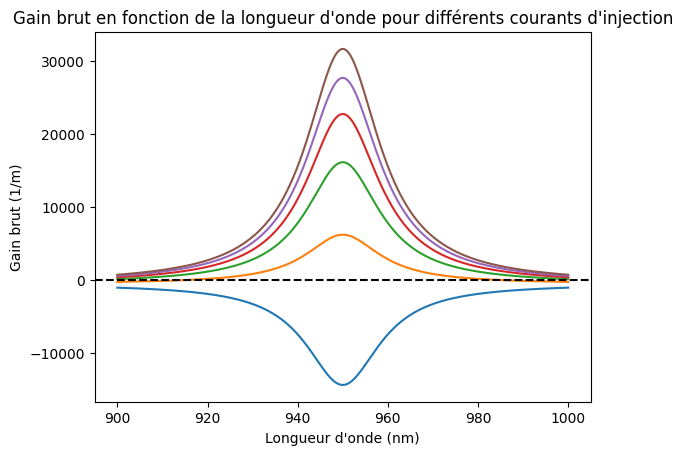

In [426]:
I_lis = np.linspace(5e-3, 50e-3, 6)
λ_array = np.linspace(900e-9, 1000e-9, 1000) 

for I in I_lis:
    g = calculate_gain(λ_array, I, g_0, λ_0, Δλ, I_tr)
    net_gain = Γ * g - α
    plt.plot(λ_array*1e9, net_gain, label=f"I = {I*1e3:.1f} mA")

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain brut (1/m)")
plt.title("Gain brut en fonction de la longueur d'onde pour différents courants d'injection")
plt.axhline(0, color='black', linestyle='--')
plt.show()

Les longueurs d'onde permise sont
$$ \lambda_{res} = \frac{2 n_{eff} L}{m}. $$

In [427]:
def calculate_m_central(λ_0, n_g, L):
    """ Calcule l'ordre de résonance central m_c pour une cavité de longueur L à la longueur d'onde λ_0
    """
    m_c = round((2 * n_g * L) / λ_0)
    return m_c

In [428]:
m = np.linspace(0, 1000, 1000, dtype=int)
λ_res = (2 * n_g * L) / m
nombre = 10

m_central = calculate_m_central(λ_0, n_g, L)

λ_central = (2 * n_g * L) / m_central
print(f"Mode d'ordre central m_central = {m_central} avec une longueur d'onde λ_central = {λ_central*1e9:.1f} nm")

λ_autour = λ_res[m_central - nombre:m_central + nombre + 1]  # Sélectionner les modes autour du mode central
print(λ_autour)
print(f"Longueurs d'onde des modes résonants autour de λ_0 = {λ_0*1e9:.1f} nm :")
for i in λ_autour:
    print(f" - {i*1e9:.1f} nm")

Mode d'ordre central m_central = 947 avec une longueur d'onde λ_central = 950.4 nm
[9.60512273e-07 9.59488273e-07 9.58466454e-07 9.57446809e-07
 9.56429330e-07 9.55414013e-07 9.54400848e-07 9.53389831e-07
 9.52380952e-07 9.51374207e-07 9.50369588e-07 9.49367089e-07
 9.48366702e-07 9.47368421e-07 9.46372240e-07 9.45378151e-07
 9.44386149e-07 9.43396226e-07 9.42408377e-07 9.41422594e-07
 9.40438871e-07]
Longueurs d'onde des modes résonants autour de λ_0 = 950.0 nm :
 - 960.5 nm
 - 959.5 nm
 - 958.5 nm
 - 957.4 nm
 - 956.4 nm
 - 955.4 nm
 - 954.4 nm
 - 953.4 nm
 - 952.4 nm
 - 951.4 nm
 - 950.4 nm
 - 949.4 nm
 - 948.4 nm
 - 947.4 nm
 - 946.4 nm
 - 945.4 nm
 - 944.4 nm
 - 943.4 nm
 - 942.4 nm
 - 941.4 nm
 - 940.4 nm


C:\Users\Éloi Blouin\AppData\Local\Temp\ipykernel_13712\3602766615.py:2: RuntimeWarning: divide by zero encountered in divide
  λ_res = (2 * n_g * L) / m


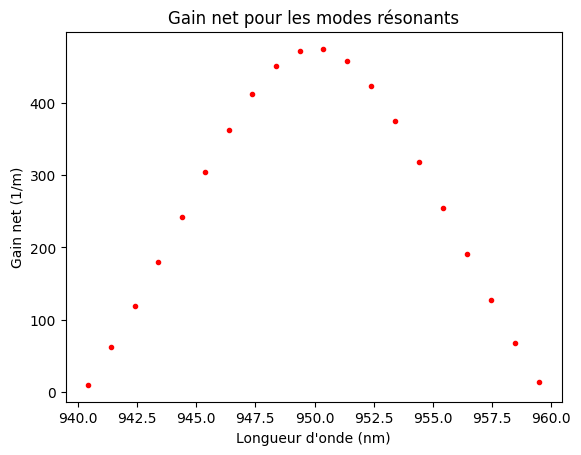

Longueurs d'onde des modes résonants à l'intérieur de la bande passante à -3dB du gain pour 10.500 mA :
λ = 959.49 nm, Gain = 13.51 1/m
λ = 958.47 nm, Gain = 68.38 1/m
λ = 957.45 nm, Gain = 127.71 1/m
λ = 956.43 nm, Gain = 190.41 1/m
λ = 955.41 nm, Gain = 254.61 1/m
λ = 954.40 nm, Gain = 317.48 1/m
λ = 953.39 nm, Gain = 375.23 1/m
λ = 952.38 nm, Gain = 423.45 1/m
λ = 951.37 nm, Gain = 457.72 1/m
λ = 950.37 nm, Gain = 474.47 1/m
λ = 949.37 nm, Gain = 471.91 1/m
λ = 948.37 nm, Gain = 450.45 1/m
λ = 947.37 nm, Gain = 412.60 1/m
λ = 946.37 nm, Gain = 362.32 1/m
λ = 945.38 nm, Gain = 304.05 1/m
λ = 944.39 nm, Gain = 241.97 1/m
λ = 943.40 nm, Gain = 179.48 1/m
λ = 942.41 nm, Gain = 119.04 1/m
λ = 941.42 nm, Gain = 62.19 1/m
λ = 940.44 nm, Gain = 9.78 1/m


In [429]:
λ_inside_3dB = []
gain_inside_3dB = []
I_test = 10.5e-3  # en A Juste pour tracer le gain aux modes résonants

for λ in λ_res:
    if λ > (λ_0 - Δλ/2) and λ < (λ_0 + Δλ/2):
        g = calculate_gain(λ, I_test, g_0, λ_0, Δλ, I_tr)
        net_gain = Γ * g - α
        plt.plot(λ*1e9, net_gain, 'r.')
        λ_inside_3dB.append(λ)
        gain_inside_3dB.append(net_gain)


plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain net (1/m)")
plt.title("Gain net pour les modes résonants")
plt.show()

print(f"Longueurs d'onde des modes résonants à l'intérieur de la bande passante à -3dB du gain pour {I_test*1000:.3f} mA :")
for i in range(len(λ_inside_3dB)):
    λ = λ_inside_3dB[i]
    gain = gain_inside_3dB[i]
    print(f"λ = {λ*1e9:.2f} nm, Gain = {gain:.2f} 1/m")


##### 2.B (5%) Tracer le gain $g(I,\lambda)$ pour $I = [10, 15, 20, 25]$ mA ainsi que le gain seuil du laser $g_{th}$. Qu'en déduisez-vous?

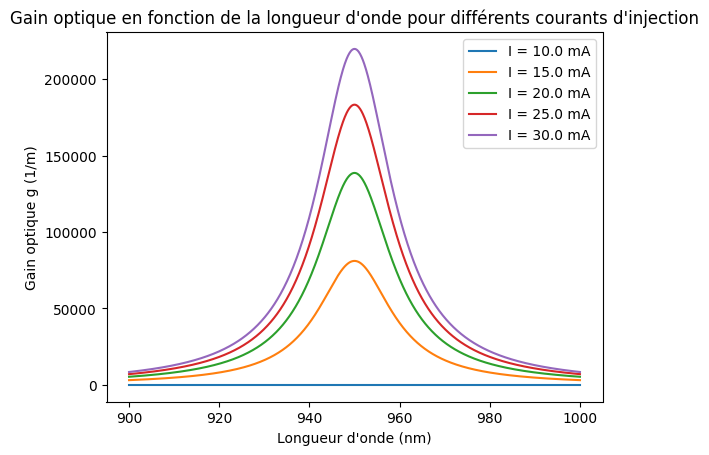

In [430]:
I_list = [10, 15, 20, 25, 30] 
I_list = [I*1e-3 for I in I_list]


gain_brute = {}
for i in range(len(I_list)):
    I = I_list[i]
    gain = calculate_gain(λ_array, I, g_0, λ_0, Δλ, I_tr)
    gain_brute[I] = gain
    plt.plot(λ_array*1e9, gain, label=f"I = {I*1e3:.1f} mA")

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain optique g (1/m)")
plt.title("Gain optique en fonction de la longueur d'onde pour différents courants d'injection")
plt.legend()
plt.show()

Pour calculer le gain seui, il reste à enlever la partie d'atténuation $α$.
Nous savons que le gain seuil arrive à partir du moment où le gain et les pertes sont égal.
$$g_{th}Γ =  α\\ g_{th} = \frac{α}{Γ} = \frac{500}{0.1} = 5000 \ [\rm{1/m}]  $$


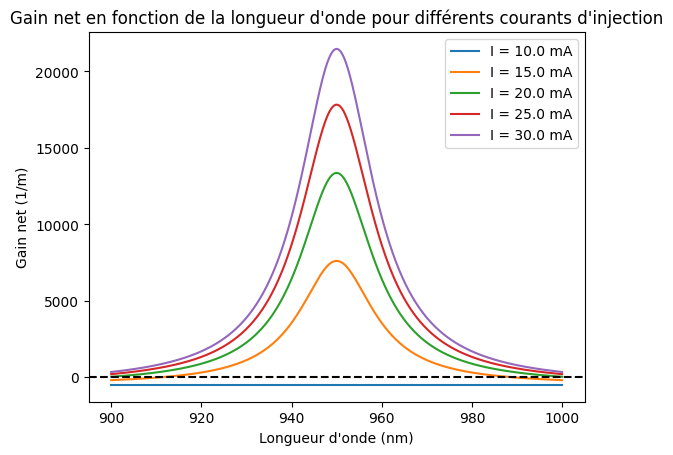

In [431]:
g_th = 5000 # 1/m

gain_values = {}
for I in I_list:
    gain = gain_brute[I]
    net_gain = Γ * gain - α
    gain_values[I] = net_gain
    plt.plot(λ_array*1e9, net_gain, label=f"I = {I*1e3:.1f} mA")

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain net (1/m)")
plt.title("Gain net en fonction de la longueur d'onde pour différents courants d'injection")
plt.legend()
plt.axhline(0, color='black', linestyle='--')
plt.show()

Il y a seulement quelques modes qui dépassent le gain seuil, donc seulement ces modes pourront amplifier la lumière et participer au fonctionnement du laser. Aussi plus le courrant est élevé, plus il y a une plage de longueur d'onde qui est au dessus du seuil qui sera amplifié.

##### 2.C (5%) Quel est le courant seuil du mode central de la cavité? Sur quelle plage de courant le laser est-il monomode (émet un seul mode laser)?

On regarde à la longueur d'onde central du laser, quel doit être le courant pour que le gain net soit plus grand que 0. On refait le même procédé pour les deux modes suivantes c'est à dire $m = 946 $ et $m = 948$.

In [432]:
m = [m_central - 1, m_central, m_central + 1]
λ_centraux = [λ_res[m_central - 1],  λ_res[m_central], λ_res[m_central + 1]]

print(f"λ_centraux = {λ_centraux}")

gain_net_centraux = [[]]* len(λ_centraux)

current_monomode = None
current_multimode = None
current_array = np.linspace(10e-3, 100e-3, 25)
for i in current_array:
    for j in range(len(λ_centraux)):
        (gain_net_centraux[j]).append(calculate_gain(λ_centraux[j], i, g_0, λ_0, Δλ, I_tr)*Γ - α)



for i in range(len(current_array)):
    print(f"Courant: {i*1e3:.2f} mA, nm, Gain net: {gain_net_centraux[1][i]:.2f} 1/m")

λ_centraux = [np.float64(9.513742071881608e-07), np.float64(9.503695881731786e-07), np.float64(9.493670886075951e-07)]
Courant: 0.00 mA, nm, Gain net: -500.00 1/m
Courant: 1000.00 mA, nm, Gain net: -500.00 1/m
Courant: 2000.00 mA, nm, Gain net: -500.00 1/m
Courant: 3000.00 mA, nm, Gain net: 5751.03 1/m
Courant: 4000.00 mA, nm, Gain net: 5860.39 1/m
Courant: 5000.00 mA, nm, Gain net: 5843.66 1/m
Courant: 6000.00 mA, nm, Gain net: 10484.87 1/m
Courant: 7000.00 mA, nm, Gain net: 10677.05 1/m
Courant: 8000.00 mA, nm, Gain net: 10647.66 1/m
Courant: 9000.00 mA, nm, Gain net: 14296.02 1/m
Courant: 10000.00 mA, nm, Gain net: 14554.87 1/m
Courant: 11000.00 mA, nm, Gain net: 14515.29 1/m
Courant: 12000.00 mA, nm, Gain net: 17486.16 1/m
Courant: 13000.00 mA, nm, Gain net: 17800.82 1/m
Courant: 14000.00 mA, nm, Gain net: 17752.70 1/m
Courant: 15000.00 mA, nm, Gain net: 20229.59 1/m
Courant: 16000.00 mA, nm, Gain net: 20592.24 1/m
Courant: 17000.00 mA, nm, Gain net: 20536.78 1/m
Courant: 18000.00 

Ok, c'était un test, pour faire du beau python, je vais définir une fonction qui calcul le courrant de seuil pour une certaine longueur d'onde. Je vais ensuite calculé les courrant seuil pour les deux modes adjagent et trouvé la plage de courrant monomode.

In [433]:
def find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α):
    """
    Trouve le courant seuil pour lequel le gain net devient supérieur à 0
    Retourne:
        I_th : courant seuil (A) où le gain net = 0
    """
    
    # Fonction du gain net
    def gain_net(I):
        g = calculate_gain(λ, I, g_0, λ_0, Δλ, I_tr)
        return Γ * g - α
    
    for I in np.linspace(5e-3, 15e-3, 100000):
        if gain_net(I) >= 0:
            I_th = I
            break
    else:
        I_th = None  # Si aucun courant ne satisfait la condition
    return I_th

Mode m = 946, λ = 951.37 nm : I_th = 10.258 mA
Mode m = 947, λ = 950.37 nm : I_th = 10.254 mA
Mode m = 948, λ = 949.37 nm : I_th = 10.254 mA


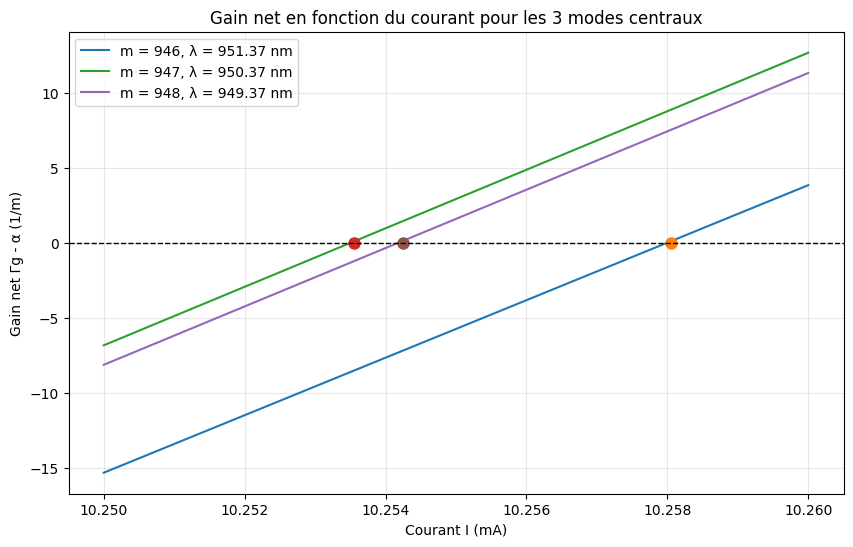

In [434]:
m = [m_central - 1, m_central, m_central + 1]
λ_centraux = [λ_res[m_central - 1], λ_res[m_central], λ_res[m_central + 1]]

# Trouver le courant seuil pour chaque longueur d'onde centrale
I_th_centraux = []
for i, λ in enumerate(λ_centraux):
    I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
    I_th_centraux.append(I_th)
    print(f"Mode m = {m[i]}, λ = {λ*1e9:.2f} nm : I_th = {I_th*1e3:.3f} mA")

# Visualisation du gain net en fonction du courant pour les 3 modes
current_array = np.linspace(10.25e-3, 10.26e-3, 200)


plt.figure(figsize=(10, 6))
for i, λ in enumerate(λ_centraux):
    gain_net_array = []
    for I in current_array:
        g = calculate_gain(λ, I, g_0, λ_0, Δλ, I_tr)
        gain_net = Γ * g - α
        gain_net_array.append(gain_net)
    
    plt.plot(current_array*1e3, gain_net_array, label=f"m = {m[i]}, λ = {λ*1e9:.2f} nm")
    
    # Marquer le courant seuil
    if I_th_centraux[i] is not None:
        plt.plot(I_th_centraux[i]*1e3, 0, 'o', markersize=8)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Courant I (mA)")
plt.ylabel("Gain net Γg - α (1/m)")
plt.title("Gain net en fonction du courant pour les 3 modes centraux")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


On trouve alors que la plage monomode est très petite

In [435]:

# Identification de la plage monomode
I_th_central = I_th_centraux[1]  
I_th_adjacent_min = min(I_th_centraux[0], I_th_centraux[2])  # Premier mode adjacent à atteindre le seuil

print(f"\n--- Plage de fonctionnement monomode ---")
print(f"Courant seuil du mode central (m = {m[1]}): I_th = {I_th_central*1e3} mA")
print(f"Courant seuil du premier mode adjacent: I_th_adj = {I_th_adjacent_min*1e3} mA")
print(f"Plage monomode: {I_th_central*1e3:.3f} mA < I < {I_th_adjacent_min*1e3} mA\n")
print(f"Largeur de la plage monomode: ΔI = {(np.abs(I_th_adjacent_min - I_th_central))*1e9} nA")



--- Plage de fonctionnement monomode ---
Courant seuil du mode central (m = 947): I_th = 10.253552535525355 mA
Courant seuil du premier mode adjacent: I_th_adj = 10.254252542525425 mA
Plage monomode: 10.254 mA < I < 10.254252542525425 mA

Largeur de la plage monomode: ΔI = 700.0070000699743 nA


##### 2.D (5%) Proposez une méthode pour augmenter la plage d'opération monomode calculée en C. Justifiez avec un calcul.

En réduisant la longueur de la cavité FP, on peut espacer les modes et ainsi avoir une plage mono-mode plus grande.

In [436]:
L_test = [100,  50, 10, 5]  # en µm
L_test = [L_val*1e-6 for L_val in L_test]  # Convertir en m


# Boucle unique pour traiter chaque longueur de cavité
for L_cavity in L_test:
    m_central = calculate_m_central(λ_0, n_g, L_cavity)
    λ_central = (2 * n_g * L_cavity) / m_central
    FSR = calculate_FSR(λ_central, L_cavity, n_g)
    λ_centraux = [ (2 * n_g * L_cavity) / (m_central - 1),  (2 * n_g * L_cavity) / m_central, (2 * n_g * L_cavity) / (m_central + 1)]
    
    I_th_centraux = []
    for i, λ in enumerate(λ_centraux):
        I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
        I_th_centraux.append(I_th)
    
    I_th_central = I_th_centraux[1]  
    I_th_adjacent_min = min(I_th_centraux[0], I_th_centraux[2])  
    print(f"L = {L_cavity*1e6:.0f} µm : Plage monomode: {I_th_central*1e3:.3f} mA < I < {I_th_adjacent_min*1e3:.3f} mA | ΔI = {np.abs(I_th_adjacent_min - I_th_central)*1e6:.2f} μA | FSR = {FSR*1e9:.2f} nm")


L = 100 µm : Plage monomode: 10.254 mA < I < 10.254 mA | ΔI = 0.70 μA | FSR = 1.00 nm
L = 50 µm : Plage monomode: 10.254 mA < I < 10.258 mA | ΔI = 3.80 μA | FSR = 2.00 nm
L = 10 µm : Plage monomode: 10.271 mA < I < 10.396 mA | ΔI = 125.40 μA | FSR = 9.97 nm
L = 5 µm : Plage monomode: 10.396 mA < I < 10.662 mA | ΔI = 265.30 μA | FSR = 20.37 nm


In [437]:
#HERe

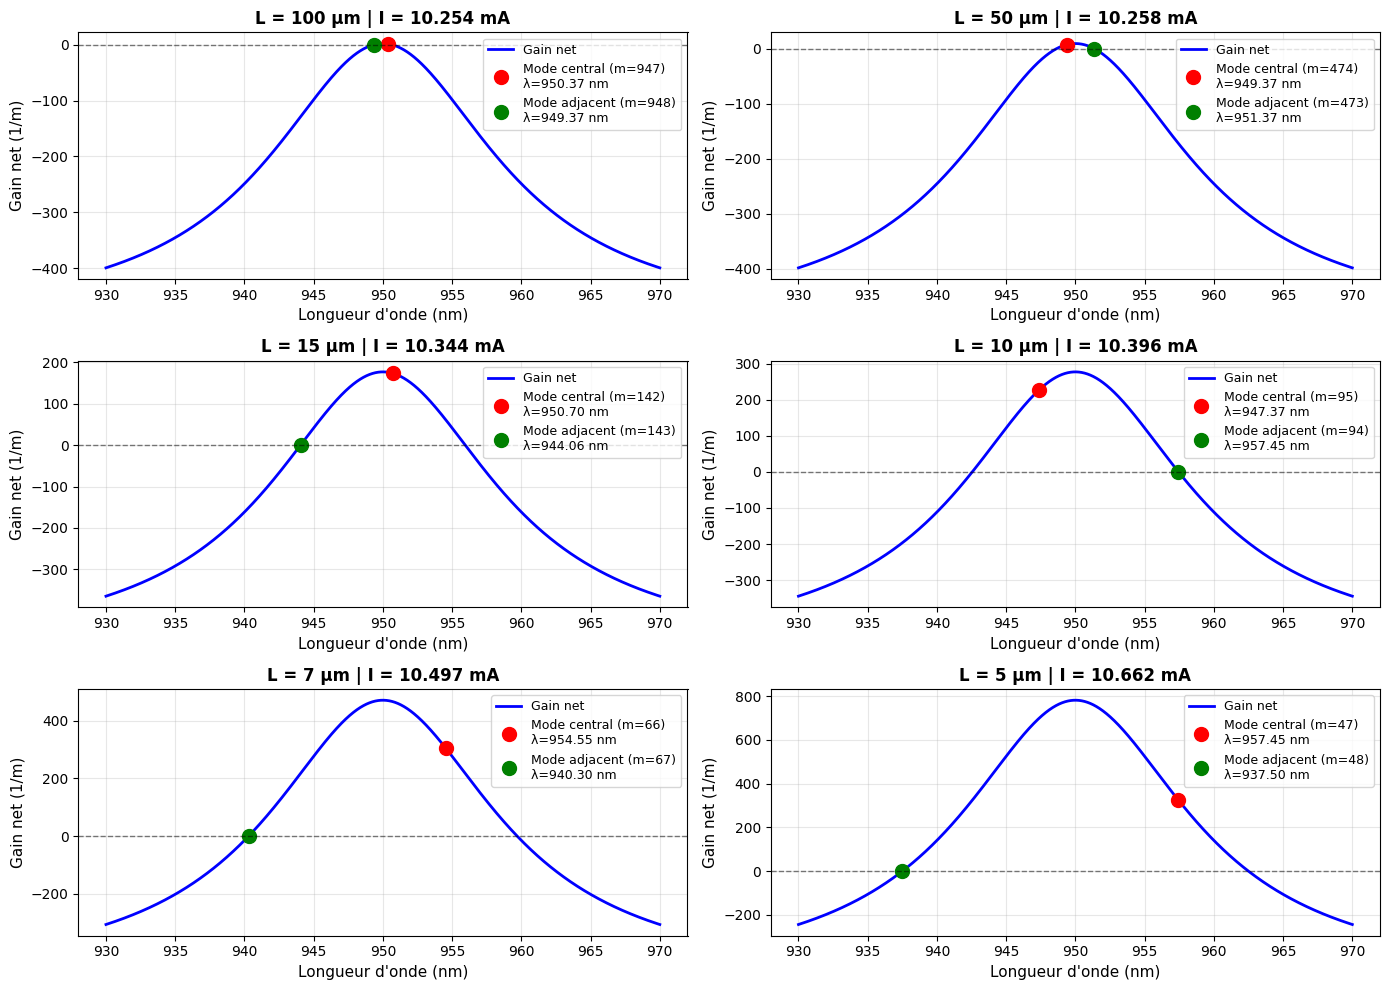


RÉSUMÉ DES RÉSULTATS POUR CHAQUE LONGUEUR DE CAVITÉ

L = 100 µm:
  Mode central: m = 947, λ = 950.37 nm, I_th = 10.254 mA
  Mode adjacent: m = 948, λ = 949.37 nm
  I_th_adjacent_min = 10.254 mA
  FSR = 1.00 nm
  Plage monomode: ΔI = 0.70 µA

L = 50 µm:
  Mode central: m = 474, λ = 949.37 nm, I_th = 10.254 mA
  Mode adjacent: m = 473, λ = 951.37 nm
  I_th_adjacent_min = 10.258 mA
  FSR = 2.00 nm
  Plage monomode: ΔI = 3.80 µA

L = 15 µm:
  Mode central: m = 142, λ = 950.70 nm, I_th = 10.254 mA
  Mode adjacent: m = 143, λ = 944.06 nm
  I_th_adjacent_min = 10.344 mA
  FSR = 6.70 nm
  Plage monomode: ΔI = 89.70 µA

L = 10 µm:
  Mode central: m = 95, λ = 947.37 nm, I_th = 10.271 mA
  Mode adjacent: m = 94, λ = 957.45 nm
  I_th_adjacent_min = 10.396 mA
  FSR = 9.97 nm
  Plage monomode: ΔI = 125.40 µA

L = 7 µm:
  Mode central: m = 66, λ = 954.55 nm, I_th = 10.306 mA
  Mode adjacent: m = 67, λ = 940.30 nm
  I_th_adjacent_min = 10.497 mA
  FSR = 14.46 nm
  Plage monomode: ΔI = 191.10 µA

L = 

In [438]:
L_test = [100, 50,15, 10, 7, 5]  # en µm
L_test_meters = [L_val*1e-6 for L_val in L_test]  # Convertir en m

# Plage de longueurs d'onde pour tracer le gain
λ_array = np.linspace(930e-9, 970e-9, 10000)

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, L_cavity in enumerate(L_test_meters):
    ax = axes[idx]
    
    # Calculer les modes résonants pour cette longueur de cavité
    m_central = calculate_m_central(λ_0, n_g, L_cavity)
    λ_res_cavity = (2 * n_g * L_cavity) / m_central
    
    # Longueurs d'onde des modes central et adjacents
    λ_central = (2 * n_g * L_cavity) / m_central
    λ_adjacent_1 = (2 * n_g * L_cavity) / (m_central - 1)
    λ_adjacent_2 = (2 * n_g * L_cavity) / (m_central + 1)
    
    # Identifier le mode adjacent le plus proche
    if abs(λ_adjacent_1 - λ_0) < abs(λ_adjacent_2 - λ_0):
        λ_adjacent_closest = λ_adjacent_1
        m_adjacent = m_central - 1
    else:
        λ_adjacent_closest = λ_adjacent_2
        m_adjacent = m_central + 1
    
    # Calculer les courants seuils
    λ_centraux_temp = [λ_adjacent_1, λ_central, λ_adjacent_2]
    I_th_centraux_temp = []
    for λ in λ_centraux_temp:
        I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
        I_th_centraux_temp.append(I_th)
    
    # Trouver I_th_adjacent_min
    I_th_central = I_th_centraux_temp[1]
    I_th_adjacent_min = min(I_th_centraux_temp[0], I_th_centraux_temp[2])
    
    # Calculer le gain net sur toute la plage λ_array à I_th_adjacent_min
    gain_net_array = []
    for λ in λ_array:
        g = calculate_gain(λ, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
        gain_net = Γ * g - α
        gain_net_array.append(gain_net)
    
    # Tracer la courbe de gain
    ax.plot(λ_array*1e9, gain_net_array, 'b-', linewidth=2, label='Gain net')
    
    # Calculer et marquer le gain au mode central
    g_central = calculate_gain(λ_central, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
    gain_net_central = Γ * g_central - α
    ax.plot(λ_central*1e9, gain_net_central, 'ro', markersize=10, 
            label=f'Mode central (m={m_central})\nλ={λ_central*1e9:.2f} nm')
    
    # Calculer et marquer le gain au mode adjacent le plus proche
    g_adjacent = calculate_gain(λ_adjacent_closest, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
    gain_net_adjacent = Γ * g_adjacent - α
    ax.plot(λ_adjacent_closest*1e9, gain_net_adjacent, 'go', markersize=10,
            label=f'Mode adjacent (m={m_adjacent})\nλ={λ_adjacent_closest*1e9:.2f} nm')
    
    # Ligne de référence à gain = 0
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Annotations
    ax.set_xlabel('Longueur d\'onde (nm)', fontsize=11)
    ax.set_ylabel('Gain net (1/m)', fontsize=11)
    ax.set_title(f'L = {L_test[idx]} µm | I = {I_th_adjacent_min*1e3:.3f} mA', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

# Afficher un résumé des informations
print("\n" + "="*80)
print("RÉSUMÉ DES RÉSULTATS POUR CHAQUE LONGUEUR DE CAVITÉ")
print("="*80)
for idx, L_cavity in enumerate(L_test_meters):
    m_central = calculate_m_central(λ_0, n_g, L_cavity)
    λ_central = (2 * n_g * L_cavity) / m_central
    λ_adjacent_1 = (2 * n_g * L_cavity) / (m_central - 1)
    λ_adjacent_2 = (2 * n_g * L_cavity) / (m_central + 1)
    
    if abs(λ_adjacent_1 - λ_0) < abs(λ_adjacent_2 - λ_0):
        λ_adjacent_closest = λ_adjacent_1
        m_adjacent = m_central - 1
    else:
        λ_adjacent_closest = λ_adjacent_2
        m_adjacent = m_central + 1
    
    λ_centraux_temp = [λ_adjacent_1, λ_central, λ_adjacent_2]
    I_th_centraux_temp = []
    for λ in λ_centraux_temp:
        I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
        I_th_centraux_temp.append(I_th)
    
    I_th_central = I_th_centraux_temp[1]
    I_th_adjacent_min = min(I_th_centraux_temp[0], I_th_centraux_temp[2])
    
    FSR = calculate_FSR(λ_central, L_cavity, n_g)
    
    print(f"\nL = {L_test[idx]} µm:")
    print(f"  Mode central: m = {m_central}, λ = {λ_central*1e9:.2f} nm, I_th = {I_th_central*1e3:.3f} mA")
    print(f"  Mode adjacent: m = {m_adjacent}, λ = {λ_adjacent_closest*1e9:.2f} nm")
    print(f"  I_th_adjacent_min = {I_th_adjacent_min*1e3:.3f} mA")
    print(f"  FSR = {FSR*1e9:.2f} nm")
    print(f"  Plage monomode: ΔI = {np.abs(I_th_adjacent_min - I_th_central)*1e6:.2f} µA")
print("="*80)

In [439]:
reset_globals_variables()

### Question 3 - Laser Fabry-Perot (20%)
Considérez un laser de Fabry-Perot avec les caractéristiques suivantes:

| Paramètre du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
|Dimensions transverses de la cavité | $d \times w$ | 0.2 $\times$ 1 | $\mu m$ |
|Efficacité d'injection | $\eta_i$ | 0.9 | -|
|Longueur de la cavité | $L$ | 500 | $\mu$ m |
|Coefficient de pertes | $\alpha_i$ | 10 | cm $^{-1}$ |
|Facteur de confinement | $\Gamma$ | 0.01 | - |
|Indice de groupe | $n_g$ | 3.65 | - |
|Coefficient de réflexion des miroirs | $r_{1,2}$ | 0.99, 0.8 | - |
|Temps de vie des porteurs | $\tau$ | 3 | ns |
|Longueur d'onde d'émission| $\lambda_0$ | 900 | nm |
|Densité de porteurs à la transparence| $N_{tr}$ | $1.1 \times 10^{18}$ | $ cm ^{-3}$ |
|Coefficient de gain nominal| $g_0$ | 2000 | $cm ^{-1}$ |

Utilisez un modèle de gain  logarithmique tel que vu en classe et assumez le cas limite $g\ge0 $ et négligez la compression du gain ($\epsilon = 0$). Faites l'analyse pour un seul mode.

In [440]:
d = 0.2e-6
w = 1e-6
η_i = 0.9
L = 500e-6
α_i = 10 * 100 # 1/m
Γ = 0.01
n_g = 3.65
r_1 = 0.99
r_2 = 0.8
τ = 3e-9
λ_0 = 900e-9
N_tr = 1.1e18 * 1e6
g_0 = 2000 * 100

##### 3.A (5%) Calculer le courant de seuil du laser $I_{th}$.

Le courant seuil est trouvé à l'aide de l'équation $$ g(N) = g_0\ln{\cfrac{N}{N_{tr}}}\\ I_{th} = \cfrac{n_{th}eLWd}{τ_r}$$ à laquel il faut ajouter l'éfficacité d'injection.
$$ I_{th} = \cfrac{n_{th}eLWd}{η_iτ_r}$$
Nous avons besoin de la densité de porteur de charge threshold $n_{th}$. Celui-çi ce trouve avec l'équation 
$$g(n_{th}) = g_0\ln{\cfrac{n_{th}}{N_{tr}}}\\ e^{g_{th}/g_0}⋅N_{tr} = n_{th}$$
 où l'on trouve le gain seuil à l'aide des pertes dans la cavité $α$ avec la relation suivante $g_{th} = \frac{α_{tot}}{Γ}$.

$$α = α_m + α_i = -\frac{1}{L}\ln{(r_1r_2)} + α_i $$

In [441]:
def calculate_threshold_current(d, w, L, α_int, Γ, g_0, N_tr, r_1, r_2, η, τ):
    """ Calcule le courant seuil I_th d'un laser à cavité Fabry-Perot

    Paramètres:
        d : épaisseur de la région active en m
        w : largeur de la région active en m
        L : longueur de la cavité en m
        α_i : pertes internes en 1/m
        Γ : facteur de confinement optique (sans unité)
        g_0 : gain optique par inversion de population en 1/m
        N_tr : densité de porteurs à la transparence en 1/m^3
        n_g : indice de groupe (sans unité)
        r_1, r_2 : coefficients de réflexion des miroirs (sans unité)
        η : efficacité de l'injection (sans unité)
        τ : temps de vie des porteurs en s

    Retourne:
        I_th : courant seuil en A
    """
    # Calcul des pertes totales
    α_tot = α_int - np.log(r_1 * r_2) / (L)
    print(f"Pertes totales α_tot = {α_tot:.2f} 1/m")

    # Calcul du gain au seuil
    g_thres = α_tot / Γ
    print(f"Gain au seuil g_th = {g_thres:.2f} 1/m")

    # Densité de porteurs au seuil
    N_thres = N_tr * np.exp(g_thres / g_0)
    # Volume de la région active
    print(f"Densité de porteurs au seuil N_th = {N_thres:.2e} 1/m^3")

    V_active = d * w * L

    # Courant seuil
    I_th = (N_thres * V_active * cte.e) / (η * τ)

    return I_th

In [442]:
#Calcul perte total 1/m
α_tot = α_i - np.log(r_1*r_2)/(L) 
print(f"α_tot = {α_tot:.2f} 1/m")

g_th = α_tot / Γ  # en 1/m
print(f"Gain seuil = {g_th:.2f} 1/m")

N_th = N_tr*np.exp(g_th/g_0)
print(f"Densité de porteurs au seuil N_th = {N_th:.2e} m^-3")

I_th = (N_th * d * w * L * cte.e) / (η_i * τ)
print(f"Le courant seuil I_th est de {I_th*1e3:.2f} mA (calcul manuel)")

print("\n")
I_th = calculate_threshold_current(d, w, L, α_i, Γ, g_0, N_tr, r_1, r_2, η_i, τ)
print(f"Le courant seuil I_th est de {I_th*1e3:.2f} mA")


α_tot = 1466.39 1/m
Gain seuil = 146638.78 1/m
Densité de porteurs au seuil N_th = 2.29e+24 m^-3
Le courant seuil I_th est de 13.59 mA (calcul manuel)


Pertes totales α_tot = 1466.39 1/m
Gain au seuil g_th = 146638.78 1/m
Densité de porteurs au seuil N_th = 2.29e+24 1/m^3
Le courant seuil I_th est de 13.59 mA


##### 3.B (5%) Quelle est la puissance émise *par chaque facette* en régime permanent pour un courant appliqué de $I = 3 I_{th}$.

La fraction de la puissance qui sort par la facette 1 est donnée par l'équation
$$
F_1 = \frac{t_1^2}{(1-r_1^2)+\frac{r_1}{r_2} (1-r_2^2)} 
$$ 
Comme nous somme à incidence normal $t = \sqrt{1-r^2}$

Par la suite, pour trouvé l'actuelle puissance émise par la jonction sur une facette $j$ de Réflectivité $R_j = r_j^2$ avec l'éfficacité d'injection $η_i$ la formule est

$$P_j = η_i\frac{hν}{e}(I-I_{th}) \frac{α_{m_j}}{α_{tot}}$$

avec $ν = c/λ$

[$$ P_j = (I-I_{th}) \cfrac{η_ihc^2τ_{ph}(1-R_j)}{2enλL}$$]::



In [456]:
def calculate_power_facette(I, I_th, τ_ph, λ, n_g, r_i, L, η_i=1.0):
    """ Calcule la puissance de sortie P_out d'un laser à cavité Fabry-Perot

    Paramètres:
        I : courant d'injection en A
        I_th : courant seuil en A
        τ_ph : temps de vie des photons en s
        λ : longueur d'onde en m
        n_g : indice de groupe (sans unité)
        r_i : coefficient de réflexion du miroir de sortie (sans unité)

    Retourne:
        P_out : puissance de sortie en W
    """
    # À incidence normal
    R_i = r_i**2

    if I <= I_th:
        return 0.0  # Pas d'émission laser en dessous du seuil

    P_out = (I - I_th) * (η_i * cte.h * cte.c**2 * τ_ph * (1 - R_i)) / (2 * cte.e * n_g * λ * L)

    return P_out


def calculate_α_miroir(r, L_α):
    return 1 / (L_α) * np.log(1 / (r))  # en 1/m

# $$P_j = η_i\frac{nν}{e}(I-I_{th}) \frac{α_{m_j}}{α_{tot}}$$
def calculate_power_interface(η_injection, n, λ, I, I_th, r, α_tot, L_p):
    """ Calcule la puissance de sortie P_j d'un laser à cavité Fabry-Perot pour un miroir j

    Paramètres:
        η_i : efficacité d'injection (sans unité)
        n_g : indice de groupe (sans unité)
        λ : longueur d'onde en m
        I : courant d'injection en A
        I_th : courant seuil en A
        r : coefficient de réflexion du miroir j (sans unité)
        α_tot : pertes totales en 1/m
        L : longueur de la cavité en m

    Retourne:
        P_j : puissance de sortie en W
    """
    if I <= I_th:
        return 0.0  # Pas d'émission laser en dessous du seuil

    α_m_j = calculate_α_miroir(r, L_p)
    print(f"α_m_j = {α_m_j:.2f} 1/m")
    print(f"α_tot = {α_tot:.2f} 1/m")
    
    P_j = (I - I_th) * η_injection * (cte.h * cte.c) / (cte.e * λ)  * (α_m_j / α_tot)

    return P_j

Temps de vie des photons τ_ph = 8.30 ps
α_m_j = 446.29 1/m
α_tot = 1466.39 1/m
α_m_j = 20.10 1/m
α_tot = 1466.39 1/m
La puissance de sortie P_out pour r_2 = 0.8 est de 10.25470599317051 mW
La puissance de sortie P_out pour r_1 = 0.99 est de 0.4618696740429411 mW


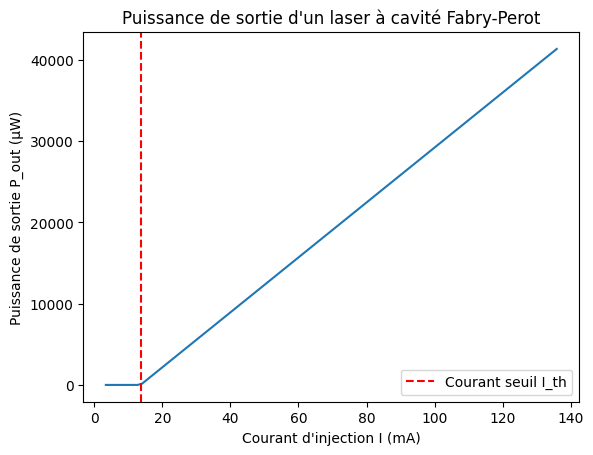

In [457]:
I = 3 * I_th  # en A



# trouvé le temps de vie des photons τ_ph à partir de α_tot
v_g = cte.c / n_g  # Vitesse de groupe
τ_ph = 1 / (v_g * α_tot)  # en s
print(f"Temps de vie des photons τ_ph = {τ_ph*1e12:.2f} ps")

P_out_2 = calculate_power_interface(η_i, n_g, λ_0, I, I_th, r_2, α_tot, L)
P_out_1 = calculate_power_interface(η_i, n_g, λ_0, I, I_th, r_1, α_tot, L)

print(f"La puissance de sortie P_out pour r_2 = {r_2} est de {P_out_2*1e3} mW")
print(f"La puissance de sortie P_out pour r_1 = {r_1} est de {P_out_1*1e3} mW")

I_array = np.linspace(I_th/4, 10*I_th, 100)

P_out_array = []
for I_val in I_array:
    P_out = calculate_power_facette(I_val, I_th, τ_ph, λ_0, n_g, r_2,L)
    P_out_array.append(P_out)
plt.plot(I_array*1e3, np.array(P_out_array)*1e6)
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Puissance de sortie P_out (µW)")
plt.title("Puissance de sortie d'un laser à cavité Fabry-Perot")
plt.axvline(I_th*1e3, color='red', linestyle='--', label='Courant seuil I_th')
plt.legend()
plt.show()



##### 3.C (5%) Quelle est l'efficacité quantique différentielle du laser? Quelle est la limite théorique maximale de l'efficacité quantique différentielle du laser?

L'efficacité quantique différentiel $P_{0,out} = η_d \frac{hν}{q}(I-I_{th})$

##### 3.D (5%) Proposez une façon d'augmenter l'efficacité quantique différentielle. Supportez par un calcul.

In [445]:
# - Réponse -

### Question 4 -  Équation de taux d'une diode laser (50%)
Considérez une version simplifiée ($\Gamma = 1$, $G = \Gamma v_g g$) des équations de taux vues en classe:

$$ \frac{dN}{dt} = \eta_i \frac{I}{e} - \frac{N}{\tau} - G N_p$$
$$ \frac{dN_p}{dt} = R^{'}_{sp} + G N_p - \frac{N_p}{\tau_p}$$

Ici, $N$ et $N_p$ représente les quantités de porteurs et de photons et non les densités. Cette distinction est importante pour l'efficacité numérique de votre solution. 

Considérez un modèle linéaire pour le gain tel que:

$$ G(N) = \frac{G_0(N - N_{tr})}{1 + \epsilon N_p} $$

Ici $\epsilon$ est le facteur de compression du gain, à ne pas confondre avec la permittivité.

Les autres paramètres du laser sont:

| Paramètre du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
|Temps de vie des photons | $\tau_p$ | 3 | ps |
|Temps de vie des porteurs | $\tau$ | 2 | ns |
|Taux d'émission spontanée | $R ^{'}_{sp}$ | 100 | ns $^{-1}$ |
|Facteur de gain | $G_0$ | $1 \times 10^{-5}$ | ns $^{-1}$ |
|Porteurs à la transparence| $N_{tr}$ | $4 \times 10^6$ | - |
|Efficacité d'injection | $\eta_i$ | 0.9 | - | 
|Facteur de compression du gain | $\epsilon$ | $2 \times 10^{-7}$ | - |
|Longueur d'onde d'émission | $\lambda_0$ | $1550$ | nm| 


##### 4.A (2.5%) Calculer *analytiquement* le courant de seuil et la quantité de porteurs au seuil du laser.

In [446]:
# - Réponse -

##### 4.B (2.5%) Quelle est la quantité de porteurs en régime permanent, au-delà du seuil?

In [447]:
# - Réponse -

*Pour le reste du problème* (C, D, E, F, G, H), vous devez résoudre les équations de taux numériquement en utilisant une librairie de Python (scipy.integrate par exemple) ou la méthode de Runge-Kutta 4 vue en classe.


##### 4.C (10%)

On vous demande d'abord de tracer les valeurs en régime permanent de $N$ et de $N_p$ en fonction du courant $I$. Le courant devrait être varier entre $I = 0$ mA et $I = 10$ mA.

Comment se compare ce que vous observez avec les valeurs obtenues en A et en B?

*** Conseil: exprimez votre variable de temps en $ns$ au lieu d'en $s$, encore une fois afin d'éviter les erreurs d'overflow. Attention à la conversion du courant. ***

*** Pour obtenir les valeurs en régime permanent, il suffit de résoudre les équations en temps jusqu'à l'atteinte de l'état stationnaire, puis de conserver seulement une valeur en R.P. ***

*** Pour résoudre les équations de taux, vous pouvez utiliser l'intégrateur numérique Runge-Kutta ou utiliser une fonction du module scipy (par exemple, https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

In [448]:
# - Réponse -

##### 4.D (5%) Tracer la puissance de sortie totale du laser (en mW) en régime permanent en fonction du courant appliqué (en mA). Assumez $\tau_m \approx \tau_p$.

In [449]:
# - Réponse -

##### 4.E (5%) Sur un graphique, tracer la densité de photons en fonction du temps pour des courants de $I = 2 I_{th}$ et de $I = 5 I_{th}$ (deux courbes). Il faut donc résoudre les équations de taux de 0 ns à 5 ns en partant avec des valeurs initiales de $[N_0, N_{p,0}] = [0,0]$. Quel est le délai d'ouverture dans les deux cas? Qu'en déduisez-vous?

In [450]:
# - Réponse -

##### 4.F (5%) Tracer la puissance de sortie du laser en fonction du temps pour un courant appliqué de $I = 2 I_{th}$ et de $I = 5 I_{th}$. Estimer la fréquence des oscillations d'ouverture dans les deux cas. Qu'en déduisez-vous?

In [451]:
# - Réponse -

##### 4.G (5%) Tracer la réponse d'ouverture du laser: sur un graphique, tracer la quantité de photons vs la quantité de porteurs pour votre simulation faite en E, qu'observez-vous?

In [452]:
# - Réponse -

##### 4.H (15%)
On vous demande maintenant de prédire la réponse fréquentielle du laser en modulation petit-signal, soit lorsque le courant appliqué a une petite composante AC superposée à une composante DC. On vous demande de le faire pour plusieurs valeurs de la composante DC: $I_{DC} = [1.2, 1.5, 2.5, 10] \times I_{th}$. 

Pour ce faire, appliqué d'abord le courant DC seulement et attendez que le laser atteigne l'état stationnaire. Ensuite, appliquez une petite perturbation au courant (un pulse). Continuer la simulation jusqu'à ce que les oscillations cessent (au moins 20 ns). Faites la transformée de Fourier des données à partir de l'introduction du pulse jusqu'à la fin de la simulation. On se rappel que la transformée de Fourier de la réponse temporelle d'un système avec une fonction delta appliquée nous donne la fréquence fréquentielle du système $S_{21}$.

Vous devez tracer la réponse fréquentielle pour chaque courant DC mentionné ci-haut et de trouver la fréquence de résonance du système. Comparez les résultats obtenus avec la réponse d'ouverture de votre laser, que remarquez-vous?

In [453]:
# - Réponse -